In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Autoencoders
En esta notebook vamos a mostrar cómo funcionan los autoencoders de redes neuronales densas

(300, 50)


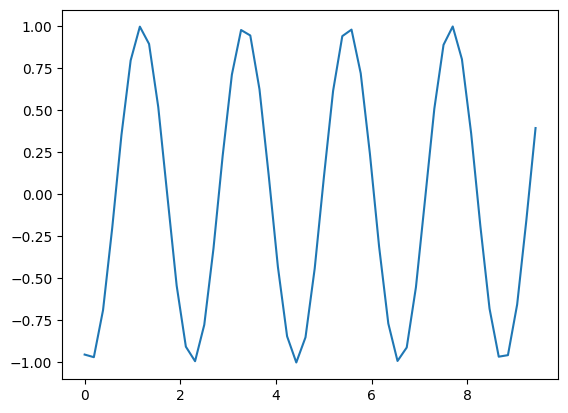

In [4]:
# vamos a trabajar con series sintéticas de funciones 
# seno, estas funciones tienen variaciones de la frecuencia y la fase 
rng = np.random.default_rng()
freq = rng.uniform(1,3, size = 300)
phase = rng.uniform(0, 2*np.pi,size = 300)
t = np.linspace(0,3*np.pi,50)
signals = np.sin(freq.reshape(-1,1) * t + phase.reshape(-1,1)) # ponemos los vectores como (sample, serie)
print(signals.shape)
plt.plot(t, signals[0])

In [5]:
# Creamos un autoencoder con 4 capas ocultas, 
# la primera capa del ENCODER expande la dimensionalidad
# pero las siguientes hacen una reducción hasta dos salidas
# el DECODER hace el proceso inverso
class AutoencoderMLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=50, out_features=64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(in_features=64, out_features=32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(in_features=32, out_features= 16),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(in_features=16, out_features= 2)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=16),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=32),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=32, out_features=64),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=64, out_features=50)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# creamos un modelo y vemos si funciona
model = AutoencoderMLP()
x_train = torch.from_numpy(signals).float()
model(x_train)

tensor([[ 0.0493,  0.0774,  0.0107,  ...,  0.1109, -0.0376, -0.1493],
        [ 0.0491,  0.0769,  0.0117,  ...,  0.1130, -0.0373, -0.1498],
        [ 0.0490,  0.0769,  0.0120,  ...,  0.1124, -0.0377, -0.1501],
        ...,
        [ 0.0492,  0.0773,  0.0109,  ...,  0.1109, -0.0377, -0.1494],
        [ 0.0490,  0.0769,  0.0120,  ...,  0.1124, -0.0377, -0.1500],
        [ 0.0491,  0.0772,  0.0112,  ...,  0.1108, -0.0380, -0.1497]],
       grad_fn=<AddmmBackward0>)

In [8]:
# proponemos un optimizador y una función de loss
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
citerion = torch.nn.MSELoss()
hist = []

In [9]:
# Entrenamos 10 epochs (pre-calentamiento) para ver si el modelo es capaz de 
# ajustarse
for i in range(10):
    pred = model(x_train)
    loss = citerion(pred, x_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    hist.append(loss.item())
    print(loss.item())

0.5083327293395996
0.5014923214912415
0.4985692799091339
0.4972490966320038
0.49498745799064636
0.4905641973018646
0.482631653547287
0.47173598408699036
0.4531894028186798
0.43660488724708557


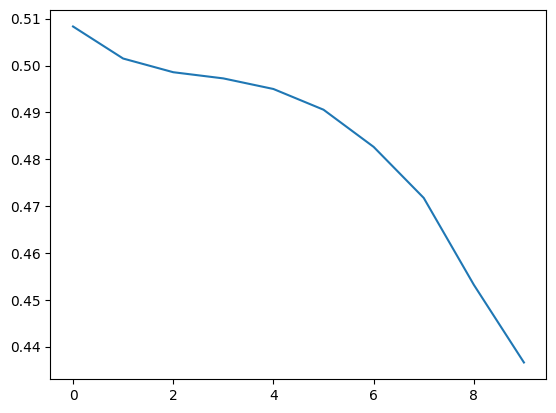

In [10]:
plt.plot(hist)

In [11]:
# Hacemos un entrenamiento de muchas epochs
for i in range(100):
    pred = model(x_train)
    loss = citerion(pred, x_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    hist.append(loss.item())
    print(loss.item())

0.42637011408805847
0.4058160185813904
0.3901275396347046
0.38003024458885193
0.3749951720237732
0.3782332241535187
0.36469772458076477
0.3582114577293396
0.3573448657989502
0.35060060024261475
0.35035476088523865
0.34637251496315
0.34917813539505005
0.3437724709510803
0.3404543101787567
0.33928316831588745
0.3325183689594269
0.32916563749313354
0.32830893993377686
0.3218643367290497
0.3182319402694702
0.31490862369537354
0.31165534257888794
0.30760952830314636
0.30080002546310425
0.3008953332901001
0.2975643575191498
0.29632365703582764
0.2916533946990967
0.2863478660583496
0.2835823595523834
0.2784307897090912
0.28176379203796387
0.2726808190345764
0.2693347632884979
0.27141091227531433
0.2666283845901489
0.26372724771499634
0.25919824838638306
0.2560015320777893
0.2537758946418762
0.2507924735546112
0.2515639066696167
0.2582555413246155
0.24635794758796692
0.2503398060798645
0.24275872111320496
0.23625241219997406
0.23773527145385742
0.24408377707004547
0.23575198650360107
0.2319911

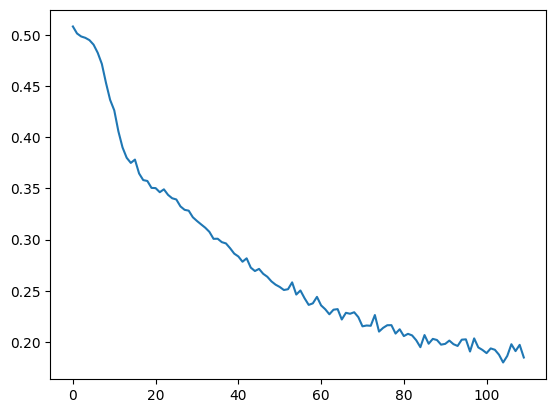

In [12]:
plt.plot(hist)

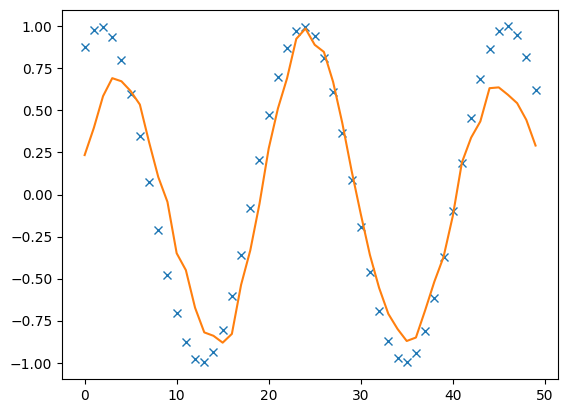

In [13]:
# ponemos en modo evaluación al modelo para apagar las capas de Dropout
# y evaluamos un ejemplo del train para ver cuánto se aprendió
model.eval()
idx = rng.integers(0,300)
plt.plot(x_train[idx,:], 'x')
plt.plot(model(x_train[idx,:].reshape(1,50)).detach().numpy().reshape(50))

Con el Autoencoder entrenado, se puede explorar el espacio latente, que es la salida del decodificador

In [33]:
# Hacemos un mapeo de funciones seno en terminos de la frecuencia y la fase
freq = np.linspace(1,3, 20)
phase = np.linspace(0, 2*np.pi, 20)
# creamos una grilla equiespaciada bidimensional de 20 frecuencias y 20 fases (matriz de 400 elementos) 
FR,PH = np.meshgrid(freq, phase)
print(FR.shape, PH.shape)

(20, 20) (20, 20)


In [26]:
t = np.linspace(0,3*np.pi,50)
mapping  = []
for i in range(20):
    for j in range(20):
        mapping.append( np.sin(FR[i,j] * t + PH[i,j], dtype=np.float32)) # ponemos los vectores como (sample, serie)

mapping = np.array(mapping)
print(mapping.shape)  # tenemos 400 funciones seno para la grilla de fases y frecuencias

(400, 50)


In [36]:
model.eval()
with torch.no_grad():  # para decirle al modelo que no compute gradientes y obvial el detach()
    latent = []
    for mapa in mapping:
        latent.append(model.encoder(torch.from_numpy(mapa.reshape(1,50))).numpy()[0]) # tomo el elemento 0 porque tira un array dentro de un array extra
latent = np.array(latent)
print(latent.shape) # hay que entender la salida

(400, 2)


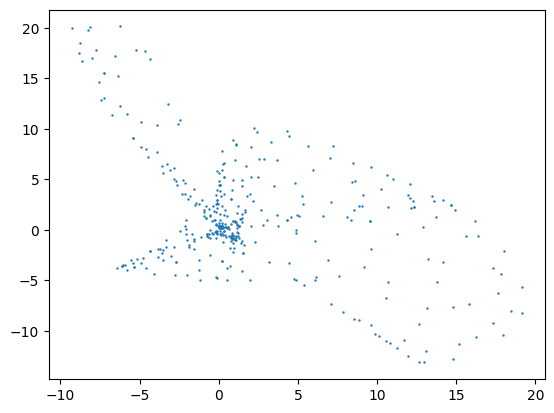

In [39]:
plt.scatter(latent[:,0], latent[:,1], s = 0.5)

En la figura anterior puede verse que cómo se compora el espacio latente para las series generadas